# **This notebook handle ML modelling**

## Objectives

* Here we create a ML model to predict diabetes based on the features engineered in the previous notebook.

## Inputs

* The input is the diabeters_model_input.csv file located in the data/transformed directory. This file was generated in the Feature_Engineering notebook. 

## Outputs

* The output file is **diabetes_risk_prediction.csv** located in the transformed data folder. 
* It has only the test set data. Without the target diabetes column. With new risk_category and risk_score columns.

## Additional Comments

* If you have any additional comments that don't fit in the previous bullets, please state them here. 



---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [26]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/Healthcare_Diabetes_Analysis'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [ ]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

Confirm the new current directory

In [ ]:
current_dir = os.getcwd()
current_dir

# ML model 

* Import the libraries needed

In [27]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score
import matplotlib.pyplot as plt

* Load the input file to a dataframe

In [28]:
df = pd.read_csv('Data/transformed/diabetes_model_input.csv')
# display the shape and first few rows of the dataframe
print(df.shape)
df.head()

(9042, 10)


,age,bmi,HbA1c_level,blood_glucose_level,hypertension,heart_disease,smoking_binned_smoker,smoking_binned_non-smoker,gender_Male,diabetes
0,80,26.40,8.20,126,0,0,1,0,1,1
1,47,43.10,4.05,159,0,0,0,1,0,0
2,26,27.32,6.00,130,0,0,1,0,0,0
3,80,27.32,7.50,160,0,0,0,0,1,1
4,57,27.32,5.80,158,0,0,0,0,1,0


* chekcking for the valule counts of the target variable

In [29]:
df['diabetes'].value_counts()

diabetes
1    4946
0    4096
Name: count, dtype: int64

* We split the data into train and test sets.

In [30]:
# Separate the features and target variable
X_train, X_test,y_train, y_test = train_test_split(
                                    df.drop(['diabetes'],axis=1),
                                    df['diabetes'],
                                    test_size=0.2,
                                   #stratify=df['diabetes'],
                                    random_state=42
                                    )
"""
Add original index to X_test for later use for prediction probabilities.
To create risk scores and categories
"""
df_xtest = df.loc[X_test.index].copy() 
print(y_test.value_counts())

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:", X_test.shape, y_test.shape)

diabetes
1    1020
0     789
Name: count, dtype: int64
* Train set: (7233, 9) (7233,) 
* Test set: (1809, 9) (1809,)


## Logistic Regression

* we create a pipeline with a scaler, feature selector and a classifier model

In [31]:
def pipeline_logistic_regression():

    pipeline = Pipeline(
        [
            ("feat_scaling", StandardScaler()),
            ("feat_selection", SelectFromModel(LogisticRegression(random_state=42))),
            ("model", LogisticRegression(random_state=42)),
        ]
    )

    return pipeline

* Fit the pipeline with the train set

In [32]:
pipeline = pipeline_logistic_regression()
pipeline.fit(X_train, y_train)

Pipeline(steps=[('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=LogisticRegression(random_state=42))),
                ('model', LogisticRegression(random_state=42))])

* Next we learn the model coefficients 

In [33]:
def logistic_regression_coef(model, columns):

    coeff_df = pd.DataFrame(
        model.coef_, index=["Coefficient"], columns=columns
    ).T.sort_values(["Coefficient"], key=abs, ascending=False)
    print(coeff_df)

In [34]:
logistic_regression_coef(
    model=pipeline["model"],
    columns=X_train.columns[pipeline["feat_selection"].get_support()],
)

                     Coefficient
HbA1c_level             2.452627
blood_glucose_level     1.823858
age                     0.914494


* Here's what we observe from the coefficients

| Feature              | Coefficient | Interpretation                                                              |
|----------------------|-------------|-----------------------------------------------------------------------------|
| HbA1c_level          | 2.45        | Strong positive impact on the probability of diabetes                       |
| blood_glucose_level  | 1.82        | Also a strong positive impact, but slightly less than HbA1c                 |
| age                  | 0.91        | Smaller positive impact, but still relevant                                 |


* The model selected the 3 features based on the importance of their logistic regression coefficients.

* Among them, HbA1c level is the most influential, followed by blood glucose level, and then age.

* The model is interpreting higher values for all three as increasing the chance of the positive outcome.

* Now we will look at the confusion matrix and classification report for performance metrics

In [35]:
def confusion_matrix_and_report(X, y, pipeline, label_map):
    
    prediction = pipeline.predict(X)

    print("---  Confusion Matrix  ---")
    print(
        pd.DataFrame(
            confusion_matrix(y_true=y, y_pred=prediction),
            columns=[["Prediction " + sub for sub in label_map]],
            index=[["Actual " + sub for sub in label_map]],
        )
    )
    print("\n")

    print("---  Classification Report  ---")
    print(classification_report(y, prediction, target_names=label_map), "\n")


def clf_performance(X_train, y_train, X_test, y_test, pipeline, label_map):
    
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train, y_train, pipeline, label_map)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test, y_test, pipeline, label_map)


In [36]:
clf_performance(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    pipeline=pipeline,
    label_map=["No Diabetes", "Diabetes"],
)

#### Train Set #### 

---  Confusion Matrix  ---
                   Prediction No Diabetes Prediction Diabetes
Actual No Diabetes                   2794                 513
Actual Diabetes                       539                3387


---  Classification Report  ---
              precision    recall  f1-score   support

 No Diabetes       0.84      0.84      0.84      3307
    Diabetes       0.87      0.86      0.87      3926

    accuracy                           0.85      7233
   macro avg       0.85      0.85      0.85      7233
weighted avg       0.85      0.85      0.85      7233
 

#### Test Set ####

---  Confusion Matrix  ---
                   Prediction No Diabetes Prediction Diabetes
Actual No Diabetes                    663                 126
Actual Diabetes                       133                 887


---  Classification Report  ---
              precision    recall  f1-score   support

 No Diabetes       0.83      0.84      0.84       789
    Diabetes       0.88   

## ✅ What Looks Good

- **Overall Accuracy is solid:**
  - Train: 85%
  - Test: 86%
  - No major signs of overfitting or underfitting.

- **Performance is slightly better for the 'Diabetes' class**, which is often the more critical one to catch:
  - Test set F1-score for Diabetes: 0.87
  - Recall for Diabetes: 0.87 (highly valuable in medical diagnosis)

- **Balanced macro averages:**  
  Precision, recall, and F1 are all around 0.85, which shows that the model doesn't heavily favor one class over another.

  ## ⚠️ What Might Be Concerning

- **False Negatives (missed diabetes cases):**
  - Test: 133 missed diabetic patients
  - That's ~13% of diabetic cases going undetected.
  - In real-world healthcare, this could be dangerous, as undiagnosed diabetes can lead to complications.

- **False Positives (wrongly predicted diabetes):**
  - Test: 126 non-diabetic people predicted as diabetic
  - This can cause anxiety, unnecessary testing, and cost.
  - Even though this number is relatively low, its impact on patient well-being should not be dismissed.

  ## ⚙️ Experimentation with Stratification and Class Weights

I experimented with applying **stratification** and **class-weight balancing** to improve model performance, especially to reduce false negatives.

- However, these changes **increased the number of false negatives**, meaning more actual diabetes cases were predicted as no diabetes.
- Since **minimizing false negatives is critical** in this healthcare context, I chose **not to keep these changes**.


### ✅ Summary
> The model demonstrates strong and balanced performance, achieving an accuracy of **85% on the training set** and **86% on the test set**. It maintains consistent precision and recall across both classes, with particularly good performance in identifying diabetes cases (**F1-score: 0.87** on the test set). The confusion matrix reveals a manageable number of false negatives and false positives, but since this is a healthcare application, further steps may be needed to validate these predictions before clinical action is taken.

---

## Random Forest Classifier

* Implementing a Random Forest Classifier to see if it improves performance over Logistic Regression.

* Define the pipeline with a scaler, feature selector and the Random Forest Classifier
    * I already did a grid search initially found the best estimators. So passed them here directly in the model step since i was encountering Kernel dying issue.

In [37]:
def pipeline_rf_clf():
  pipeline = Pipeline([
      ( "feat_scaling",StandardScaler() ),
      ( "feat_selection",SelectFromModel(RandomForestClassifier(random_state=42)) ),
      ( "model", RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)),

    ])

  return pipeline

* fit the pipeline with the train set

In [38]:
pipeline_rf = pipeline_rf_clf()
pipeline_rf.fit(X_train, y_train)

Pipeline(steps=[('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=RandomForestClassifier(random_state=42))),
                ('model',
                 RandomForestClassifier(max_depth=10, n_estimators=50,
                                        random_state=42))])

* checking for the features selected by the model

In [39]:
selected_feature = X_train.columns[pipeline_rf.named_steps['feat_selection'].get_support()]
selected_feature

Index(['age', 'bmi', 'HbA1c_level', 'blood_glucose_level'], dtype='object')

* The random forest model selected age, bmi, HbA1c_level and blood_glucose_level features.
* This matches to our findings from statistical testing from EDA as well.

* evaluate the model with a confusion matrix and classification report

In [40]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_rf,
                label_map= ['No Diabetes', 'Diabetes'] 
                )

#### Train Set #### 

---  Confusion Matrix  ---
                   Prediction No Diabetes Prediction Diabetes
Actual No Diabetes                   2915                 392
Actual Diabetes                       227                3699


---  Classification Report  ---
              precision    recall  f1-score   support

 No Diabetes       0.93      0.88      0.90      3307
    Diabetes       0.90      0.94      0.92      3926

    accuracy                           0.91      7233
   macro avg       0.92      0.91      0.91      7233
weighted avg       0.91      0.91      0.91      7233
 

#### Test Set ####

---  Confusion Matrix  ---
                   Prediction No Diabetes Prediction Diabetes
Actual No Diabetes                    668                 121
Actual Diabetes                        66                 954


---  Classification Report  ---
              precision    recall  f1-score   support

 No Diabetes       0.91      0.85      0.88       789
    Diabetes       0.89   

* plotting the feature importance from model step

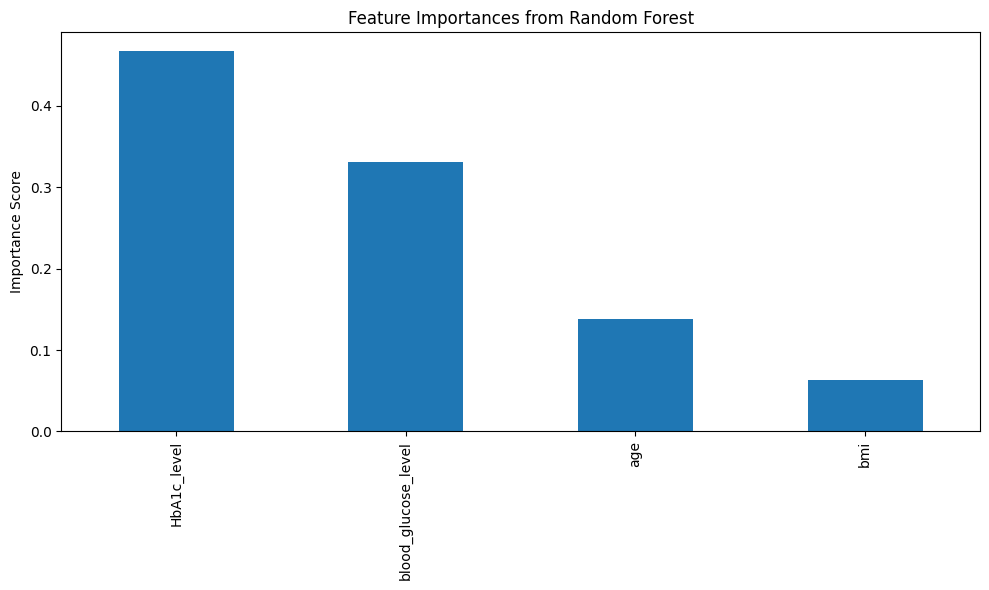

In [41]:
# Get the trained classifier
rf_model = pipeline_rf.named_steps['model']

# Use selected features only
selected_features = X_train.columns[pipeline_rf.named_steps['feat_selection'].get_support()]

# Plot feature importances
importances = rf_model.feature_importances_
feat_imp = pd.Series(importances, index=selected_features).sort_values(ascending=False)

plt.figure(figsize=(10,6))
feat_imp.plot(kind='bar')
plt.title("Feature Importances from Random Forest")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

### 🔍 Side-by-Side Comparison

#### ✅ Accuracy

| Model              | Train Accuracy | Test Accuracy |
|--------------------|----------------|---------------|
| Random Forest      | 91%            | 90%           |
| Logistic Regression | 85%            | 86%           |

> 🔹 **Winner: Random Forest** — better overall accuracy, and smaller train-test gap.

---

#### ✅ Recall (especially important for Diabetes class)

| Model              | Train Recall – Diabetes | Test Recall – Diabetes |
|--------------------|------------------------|-----------------------|
| Random Forest      | 0.94                   | 0.94                  |
| Logistic Regression | 0.86                   | 0.87                  |

> 🔹 **Winner: Random Forest** — significantly higher recall for the Diabetes class, which is crucial in medical diagnosis.

---

#### ✅ False Negatives (missed diabetes cases)

| Model              | Test False Negatives    |
|--------------------|------------------------|
| Random Forest      | 66 (6.5%)               |
| Logistic Regression | 133 (13%)               |

> 🔹 **Winner: Random Forest** — detects more true diabetes cases (almost halves the number of missed diagnoses).

### ✅ Final Verdict

Random Forest clearly outperforms Logistic Regression across all major metrics, especially in terms of recall for diabetic patients, overall accuracy, and reduction in false negatives — making it the stronger choice between the 2 models for this diabetes prediction task.

## ⚙️ Experimentation with hyperparameter optimisation

- Initially tried random forest with just 'n_estimators' but the model overfitted the training data. The recall rate in train set was 1 but it was performing poorly on the test set. 

- So added 'max_depth' to the hyperparameter grid to control the depth of each tree in the forest.

- This helped reduce overfitting and improved generalization to unseen data.

* Using the random forest classifier to generate risk score of diabetes.

In [42]:
# Get predicted probabilities for positive class (diabetes) 

df_xtest['risk_score'] = (pipeline_rf.predict_proba(X_test)[:, 1] * 100).round(2)

# Categorize into risk groups based on risk score
def categorize_risk(score):
    if score < 20:
        return 'Low'
    elif 20 <= score < 40:
        return 'Normal'
    elif 40 <= score < 60:
        return 'Medium'
    else:
        return 'High'

df_xtest['risk_category'] = df_xtest['risk_score'].apply(categorize_risk)

# View a few rows
print(df_xtest[['risk_score', 'risk_category']].head())

# checking the value counts for each risk category
df_xtest['risk_category'].value_counts()

      risk_score risk_category
1263        0.33           Low
93          2.33           Low
3316       63.51          High
3027       65.58          High
8359       16.42           Low


risk_category
High      958
Low       581
Medium    183
Normal     87
Name: count, dtype: int64

* Load this to a csv file named **diabetes_risk_prediction.csv** located in the transformed data folder.

*Note: 
    - This output or **risk prediction is only on the test set** and not on the entire dataset.
     It does not have the target diabetes column instead has only the risk_score and risk_category*

In [43]:
current_dir = os.getcwd()
current_dir

df_xtest.to_csv('Data/transformed/diabetes_risk_prediction.csv', index=False)


* Used GridSearchCV to find the best hyperparameters for the Random Forest model.
* I ran into kernel dying issue but before that I could do a successful grid seacrch and found the best hyperparameters. Hence decided to comment all the code related to grid search. 

#### The code used for grid seacrh andhyper parameter optimisation


* Used GridSearchCV to find the best hyperparameters for the Random Forest model.
* I ran into kernel dying issue but before that I could do a successful grid seacrch and found the best hyperparameters. Hence decided to comment all the code related to grid search. 

In [ ]:
# 1st attempt with just n_estimators
# param_grid = {"model__n_estimators":[50,20],
#               }

# 2nd attempt with n_estimators and max_depth
# param_grid = {
#     'model__n_estimators': [50, 100],
#     'model__max_depth': [None, 10, 20]
# }

# param_grid

# defining the grid search
# grid = GridSearchCV(estimator=pipeline_rf_clf(),
#                     param_grid=param_grid,
#                     cv=2,
#                     n_jobs=-2,
#                     verbose=1,
#                     scoring=make_scorer(recall_score, pos_label=1)
#                     )

# grid = GridSearchCV(
#     estimator=pipeline_rf_clf(),
#     param_grid=param_grid,
#     scoring=make_scorer(recall_score, pos_label=1),  # assuming 1 = 'Diabetes'
#     cv=3,
#     n_jobs=-1,
#     verbose=2
# )

# grid.fit(X_train,y_train)

# checking the results of the grid search
# (pd.DataFrame(grid.cv_results_)
# .sort_values(by='mean_test_score',ascending=False)
# .filter(['params','mean_test_score'])
# .values
#  )

# getting the best hyperparameters combinations
# grid.best_params_

---

## Conclusion and Next Steps

* Random Forest clearly outperformed Logistic Regression across all major metrics, especially in terms of recall for diabetic patients, overall accuracy, and reduction in false negatives — making it the stronger choice between the 2 models for this diabetes prediction task.

* Using this model's probability score, I predicted the risk_category on the test set and captured the results in a new csv file.

* Next we are going to do a Power BI dashboard to communicate the insights.